<a href="https://colab.research.google.com/github/Michaelmvh/bozdag-research-GNN/blob/main/Baseline_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# pip installs
!pip install torch-geometric

In [2]:
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import GCN
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import from_networkx
from sklearn.metrics import roc_auc_score

# Setup

## Constants

In [3]:
graph_location = "/content/drive/MyDrive/Colab Notebooks/Bozdag Research/Data/ChChSe-Decagon_polypharmacy.csv"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print(device)

cpu


# Load Dataset

In [5]:
def load_graph_from_edge_list(
    file_path:str,
    source_col_name:str,
    target_col_name:str,
    ignore_edge_type: bool = True):
  df = pd.read_csv(file_path)
  return nx.from_pandas_edgelist(df=df, source=source_col_name, target=target_col_name, edge_attr= None if ignore_edge_type else True)

nx_data = load_graph_from_edge_list(graph_location, '# STITCH 1', 'STITCH 2')
print(nx_data)

Graph with 645 nodes and 63473 edges


In [6]:
# This will print 2x as many edges as networkx representation because of how
# (un)directed edges are handled
data = from_networkx(nx_data)
print(data)

Data(edge_index=[2, 126946], num_nodes=645)


## Dataset information

Average Degree: 196.815503875969
Clustering Coefficient: 0.8114454293226888


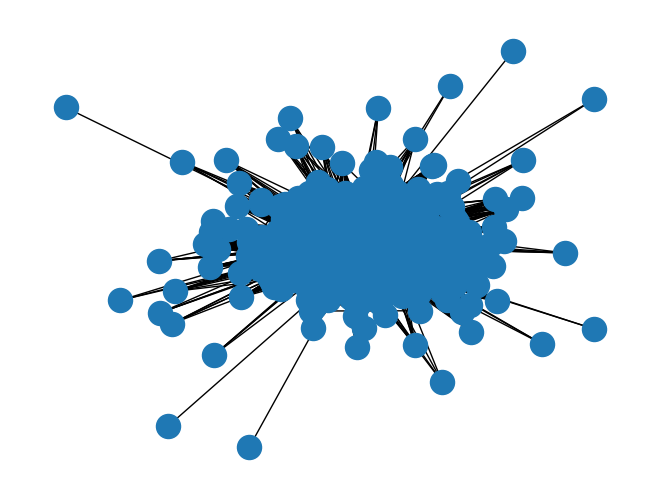

In [7]:
def print_graph_info(G: nx.Graph):
  clustering_coeff = nx.average_clustering(G)

  def avg_degree(G:nx.graph):
    return nx.number_of_edges(G)/nx.number_of_nodes(G)*2

  print(f"Average Degree: {avg_degree(G)}\nClustering Coefficient: {clustering_coeff}")
  # nx.draw(nx_data)
  nx.draw(G)

print_graph_info(nx_data)

## Define Node Features

### One-hot encoding

In [8]:
num_nodes = nx_data.number_of_nodes()
data.x = torch.eye(num_nodes)

In [9]:
print(data)

Data(edge_index=[2, 126946], num_nodes=645, x=[645, 645])


### Train/test/val split

In [10]:
# Traian, val, test split
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=True,
    split_labels=True)
train_data, val_data, test_data = transform(data)

In [11]:
print("Train: ",train_data)
print("Val: ",val_data)
print("Test: ",test_data)

Train:  Data(edge_index=[2, 88864], num_nodes=645, x=[645, 645], pos_edge_label=[44432], pos_edge_label_index=[2, 44432], neg_edge_label=[44432], neg_edge_label_index=[2, 44432])
Val:  Data(edge_index=[2, 88864], num_nodes=645, x=[645, 645], pos_edge_label=[6347], pos_edge_label_index=[2, 6347], neg_edge_label=[6347], neg_edge_label_index=[2, 6347])
Test:  Data(edge_index=[2, 101558], num_nodes=645, x=[645, 645], pos_edge_label=[12694], pos_edge_label_index=[2, 12694], neg_edge_label=[12694], neg_edge_label_index=[2, 12694])


# Graph Neural Network

## Define Model

In [12]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # Embeddings

# Model parameters
input_dim = train_data.x.size(1)
hidden_dim = 128
output_dim = 64  # Embedding size

model = GCN(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Define Decoder

In [13]:
def decode(z, edge_index):
    value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
    return value

## Define Training

In [14]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()

    # Compute node embeddings using (only) the training graph.
    z = model(data.x, data.pos_edge_label_index)

    # Positive edge predictions.
    pos_pred = torch.sigmoid(decode(z, data.pos_edge_label_index))
    # Negative edge predictions.
    neg_pred = torch.sigmoid(decode(z, data.neg_edge_label_index))

    # Use binary cross-entropy loss.
    loss = F.binary_cross_entropy(pos_pred, torch.ones_like(pos_pred)) + \
           F.binary_cross_entropy(neg_pred, torch.zeros_like(neg_pred))
    loss.backward()
    optimizer.step()
    return loss.item()

## Define Testing

In [15]:
def test(model, data, return_predictions=False):
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)  # Note: use full graph for message passing.

    pos_pred = decode(z, data.pos_edge_label_index)
    neg_pred = decode(z, data.neg_edge_label_index)


    if(return_predictions):
      predictions = torch.cat([pos_pred, neg_pred]).cpu().numpy()
      labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))]).cpu().numpy()
      return predictions, labels
    else:
      pos_score = torch.sigmoid(pos_pred)
      neg_score = torch.sigmoid(neg_pred)
      return ((pos_score > 0.5).sum() + (neg_score < 0.5).sum()) / (pos_score.size(0) + neg_score.size(0))

In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

def evaluation(predictions, labels):
  return {
    "Accuracy": accuracy_score(predictions, labels),
    "Precision": precision_score(predictions, labels),
    "Recall": recall_score(predictions, labels),
    "F1": f1_score(labels, predictions),
    "AUC": roc_auc_score(labels, predictions)
  }

## Run train and test

In [17]:
for epoch in range(1, 101):  # Train for 100 epochs
    loss = train(model, train_data, optimizer)
    if epoch%10==0:
      val_acc = test(model, val_data)
      print(f'Epoch: {epoch}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch: 10, Loss: 1.3258, Val Acc: 0.5000
Epoch: 20, Loss: 1.2267, Val Acc: 0.6050
Epoch: 30, Loss: 1.1217, Val Acc: 0.5425
Epoch: 40, Loss: 1.0816, Val Acc: 0.3521
Epoch: 50, Loss: 1.0379, Val Acc: 0.4397
Epoch: 60, Loss: 1.0314, Val Acc: 0.3766
Epoch: 70, Loss: 1.0306, Val Acc: 0.3934
Epoch: 80, Loss: 1.0299, Val Acc: 0.3822
Epoch: 90, Loss: 1.0291, Val Acc: 0.3975
Epoch: 100, Loss: 1.0603, Val Acc: 0.4423


In [18]:
acc = test(model, test_data)
print(f'Accuracy:\n {acc:.3f}')

Accuracy:
 0.447
